# Dense Model for Kinect data


## Section for Configurations and Imports

In [1]:
import os 
import tempfile

import numpy as np 
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import time
from tensorflow import keras

# MLflow dashboard
import mlflow
mlflow.set_tracking_uri('http://35.228.45.76:5000')
os.environ['GOOGLE_APPLICATION_CREDENTIALS']='../../keys/mlflow-312506-8cfad529f4fd.json'

# Import data augmentation
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from augmentation.methods import *

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [2]:
import warnings
warnings.simplefilter('ignore')

In [3]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [4]:
random_state = 47
np.random.seed(random_state)

In [5]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss', 
    verbose=1,
    patience=10,
    mode='min',
    restore_best_weights=True)

## 1. Load Prepared Dataset

In [6]:
data_path = '../../datasets/exercise_score/'
train_files = [
    'posenet_train_dataset_1.csv',
    'posenet_train_dataset_2.csv',
    'posenet_train_dataset_3.csv',
    'posenet_train_dataset_4.csv',
    'posenet_train_dataset_5.csv',
]

test_files = [
    'posenet_test_dataset_1.csv',
    'posenet_test_dataset_2.csv',
    'posenet_test_dataset_3.csv',
]
df_train = None
df_test = None

In [7]:
for file in train_files:
    try:
        dataset_train = pd.read_csv(data_path + file)
        if df_train is None:
            df_train = dataset_train
        else:
            df_train = df_train.append(dataset_train, ignore_index=True)  
    except IOError as e:
        print('Error in reading file: ', e)
print(df_train.shape, '\n')
print(df_train.head())

(902240, 27) 

       head_x     head_y  left_shoulder_x  left_shoulder_y  right_shoulder_x  \
0  421.555422  91.446746       397.484966       131.001872        461.732625   
1  421.555422  91.446746       397.484966       131.001872        461.732625   
2  421.555422  91.446746       397.484966       131.001872        461.732625   
3  421.555422  91.446746       397.484966       131.001872        461.732625   
4  421.555422  91.446746       397.484966       131.001872        461.732625   

   right_shoulder_y  left_elbow_x  left_elbow_y  right_elbow_x  right_elbow_y  \
0        132.726183    376.969123     187.96209     477.218849     180.690033   
1        132.726183    376.969123     187.96209     477.218849     180.690033   
2        132.726183    376.969123     187.96209     477.218849     180.690033   
3        132.726183    376.969123     187.96209     477.218849     180.690033   
4        132.726183    376.969123     187.96209     477.218849     180.690033   

   ...  right_hip

In [8]:
for file in test_files:
    try:
        dataset_test = pd.read_csv(data_path + file)
        if df_test is None:
            df_test = dataset_test
        else:
            df_test = df_test.append(dataset_test, ignore_index=True)  
    except IOError as e:
        print('Error in reading file: ', e)
print(df_test.shape, '\n')
print(df_test.head())

(95496, 27) 

       head_x     head_y  left_shoulder_x  left_shoulder_y  right_shoulder_x  \
0  467.659277  139.02619       439.535981         166.8307        499.239463   
1  467.659277  139.02619       439.535981         166.8307        499.239463   
2  467.659277  139.02619       439.535981         166.8307        499.239463   
3  467.659277  139.02619       439.535981         166.8307        499.239463   
4  467.659277  139.02619       439.535981         166.8307        499.239463   

   right_shoulder_y  left_elbow_x  left_elbow_y  right_elbow_x  right_elbow_y  \
0        168.796248    423.743133    117.204537     524.847597     120.283493   
1        168.796248    423.743133    117.204537     524.847597     120.283493   
2        168.796248    423.743133    117.204537     524.847597     120.283493   
3        168.796248    423.743133    117.204537     524.847597     120.283493   
4        168.796248    423.743133    117.204537     524.847597     120.283493   

   ...  right_hip_

In [9]:
X_train = df_train.drop(columns=['ExreciseScore'])
y_train = df_train[['ExreciseScore']]

In [10]:
X_test = df_test.drop(columns=['ExreciseScore'])
y_test = df_test[['ExreciseScore']]

In [11]:
input_mean_train = X_train.mean()
input_std_train = X_train.std()

X_train = (X_train - input_mean_train) / input_std_train

X_train.to_numpy()

array([[ 1.00655112, -0.34292424,  1.01664788, ...,  0.1665852 ,
         1.01787831,  0.17551828],
       [ 1.00655112, -0.34292424,  1.01664788, ...,  0.1665852 ,
         1.01787831,  0.17551828],
       [ 1.00655112, -0.34292424,  1.01664788, ...,  0.1665852 ,
         1.01787831,  0.17551828],
       ...,
       [-0.41348336, -0.7287563 , -0.41706492, ..., -0.85316316,
        -0.41487291, -0.84584677],
       [-0.41348336, -0.7287563 , -0.41706492, ..., -0.85316316,
        -0.41487291, -0.84584677],
       [-0.41348336, -0.7287563 , -0.41706492, ..., -0.85316316,
        -0.41487291, -0.84584677]])

In [12]:
input_mean_test = X_test.mean()
input_std_test = X_test.std()

X_test = (X_test - input_mean_test) / input_std_test

X_test.to_numpy()

array([[ 1.13022077,  0.22046598,  1.13794538, ...,  0.25184165,
         1.10893078,  0.28089235],
       [ 1.13022077,  0.22046598,  1.13794538, ...,  0.25184165,
         1.10893078,  0.28089235],
       [ 1.13022077,  0.22046598,  1.13794538, ...,  0.25184165,
         1.10893078,  0.28089235],
       ...,
       [-0.38547005, -0.92236276, -0.37413385, ..., -0.87610232,
        -0.40923334, -0.8257677 ],
       [-0.38547005, -0.92236276, -0.37413385, ..., -0.87610232,
        -0.40923334, -0.8257677 ],
       [-0.38547005, -0.92236276, -0.37413385, ..., -0.87610232,
        -0.40923334, -0.8257677 ]])

In [13]:
output_mean_train = y_train.mean()
output_std_train = y_train.std()

y_train = (y_train - output_mean_train) / output_std_train

y_train.to_numpy()

array([[-2.08496431],
       [-2.08496431],
       [-2.08496431],
       ...,
       [ 0.74306928],
       [ 0.74306928],
       [ 0.74306928]])

In [14]:
print('Training features shape:', X_train.shape)
print('Training labels shape:', y_train.shape, '\n')

print('Test features shape:', X_test.shape)
print('Test labels shape:', y_test.shape)

Training features shape: (902240, 26)
Training labels shape: (902240, 1) 

Test features shape: (95496, 26)
Test labels shape: (95496, 1)


## 3. Define the Model

### 3.1 Configurations

In [15]:
EPOCHS = 500
BATCH_SIZE = 150

input_dim = X_train.shape[1]
output_size = 1

activation = 'relu'
#kernel_initializer = 'he_uniform'
kernel_initializer = 'normal'
#output_activation = 'sigmoid'
output_activation = 'linear'

#optimizer = 'SGD'
#optimizer = 'RMSprop'
optimizer = 'Adam'
learning_rate = 1e-3

### 3.2 Model Architecture

In [16]:
from tensorflow.keras.metrics import MeanSquaredError, RootMeanSquaredError, MeanAbsoluteError
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense

METRICS = [
    MeanSquaredError(name="mse", dtype=None),
    MeanAbsoluteError(name="mae", dtype=None),
    RootMeanSquaredError(name="rmse", dtype=None),
]

def make_model(input_dim, loss, optimizer, learning_rate=0.001, metrics=METRICS):
    #MODEL 3 - Champ
    model = Sequential()
    model.add(Dense(128, input_dim=input_dim, kernel_initializer=kernel_initializer, activation=activation))
    model.add(Dense(64, kernel_initializer=kernel_initializer, activation=activation))
    model.add(Dense(64, kernel_initializer=kernel_initializer, activation=activation))
    model.add(Dense(output_size, activation=output_activation))
    #http://35.228.45.76:5000/#/experiments/0/runs/0b6786ed5d8f4860a817b4d514aa4de5
    
    #MODEL 2
    #model.add(Dense(128, input_dim=input_dim, kernel_initializer=kernel_initializer, activation=activation))
    #model.add(Dense(64, kernel_initializer=kernel_initializer, activation=activation))
    #model.add(Dense(32, kernel_initializer=kernel_initializer, activation=activation))
    #model.add(Dense(8, kernel_initializer=kernel_initializer, activation=activation))
    #model.add(Dense(output_size, activation=output_activation))
    #http://35.228.45.76:5000/#/experiments/0/runs/12172f32a5d64cbfbd906c9d486cb90e
    
    #MODEL 1
    #model.add(Dense(64, input_dim=input_dim, kernel_initializer=kernel_initializer, activation=activation))
    #model.add(Dense(64, kernel_initializer=kernel_initializer, activation=activation))
    #model.add(Dense(32, kernel_initializer=kernel_initializer, activation=activation))
    #model.add(Dense(8, kernel_initializer=kernel_initializer, activation=activation))
    #model.add(Dense(output_size, activation=output_activation))
    #http://35.228.45.76:5000/#/experiments/0/runs/b7f73a3ba8944e139b5280c0e13cf505
    
    
    optimizer = tf.keras.optimizers.get(optimizer)
    optimizer.learning_rate.assign(learning_rate)

    model.compile(
      optimizer=optimizer,
      loss=loss,
      metrics=metrics)

    print(model.summary())

    return model

## 4. MLflow Experimentation

### 4.1 Configurations

In [17]:
from mlflow.models.signature import ModelSignature
from mlflow.types.schema import Schema, ColSpec

input_schema = Schema([
    ColSpec("double", "head_x"),
    ColSpec("double", "head_y"),
    ColSpec("double", "left_shoulder_x"),
    ColSpec("double", "left_shoulder_y"),
    ColSpec("double", "left_elbow_x"),
    ColSpec("double", "left_elbow_y"),
    ColSpec("double", "right_shoulder_x"),
    ColSpec("double", "right_shoulder_y"),
    ColSpec("double", "right_elbow_x"),
    ColSpec("double", "right_elbow_y"),
    ColSpec("double", "left_wrist_x"),
    ColSpec("double", "left_wrist_y"),
    ColSpec("double", "right_wrist_x"),
    ColSpec("double", "right_wrist_y"),
    ColSpec("double", "left_hip_x"),
    ColSpec("double", "left_hip_y"),
    ColSpec("double", "right_hip_x"),
    ColSpec("double", "right_hip_y"),
    ColSpec("double", "left_knee_x"),
    ColSpec("double", "left_knee_y"),
    ColSpec("double", "right_knee_x"),
    ColSpec("double", "right_knee_y"),
    ColSpec("double", "left_ankle_x"),
    ColSpec("double", "left_ankle_y"),
    ColSpec("double", "right_ankle_x"),
    ColSpec("double", "right_ankle_y"),
])
output_schema = Schema([
    ColSpec("double", "ExreciseScore"),
])
signature = ModelSignature(inputs=input_schema, outputs=output_schema)

### 4.2 Helper functions

In [18]:
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()
    plt.show()

In [19]:
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score, mean_absolute_error

def eval_metrics(actual, pred):
    mse = mean_squared_error(actual, pred)
    msa = mean_absolute_error(actual, pred)
    r2 = r2_score(actual, pred)
    variance = explained_variance_score(actual, pred)
    return mse, msa, r2, variance

### 4.3 Start Run

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               3456      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 15,937
Trainable params: 15,937
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/500
4812/4812 [==============================] - 8s 1ms/step - loss: 0.6448 - mse: 0.6448 - mae: 0.6453 - rmse: 0.8002 - val_loss: 0.4960 - val_mse: 0.4960 - val_mae: 0.5400 - val_rmse: 0.7043
Epoch 2/500
4812/4812 [=====================

4812/4812 [==============================] - 6s 1ms/step - loss: 0.1796 - mse: 0.1796 - mae: 0.2888 - rmse: 0.4238 - val_loss: 0.3174 - val_mse: 0.3174 - val_mae: 0.3997 - val_rmse: 0.5634
Epoch 38/500
4812/4812 [==============================] - 6s 1ms/step - loss: 0.1769 - mse: 0.1769 - mae: 0.2862 - rmse: 0.4206 - val_loss: 0.3438 - val_mse: 0.3438 - val_mae: 0.4103 - val_rmse: 0.5863
Epoch 39/500
4812/4812 [==============================] - 6s 1ms/step - loss: 0.1752 - mse: 0.1752 - mae: 0.2849 - rmse: 0.4185 - val_loss: 0.3141 - val_mse: 0.3141 - val_mae: 0.3927 - val_rmse: 0.5604
Epoch 40/500
4812/4812 [==============================] - 6s 1ms/step - loss: 0.1749 - mse: 0.1749 - mae: 0.2844 - rmse: 0.4182 - val_loss: 0.3623 - val_mse: 0.3623 - val_mae: 0.4203 - val_rmse: 0.6019
Epoch 41/500
4812/4812 [==============================] - 6s 1ms/step - loss: 0.1719 - mse: 0.1719 - mae: 0.2820 - rmse: 0.4146 - val_loss: 0.3278 - val_mse: 0.3278 - val_mae: 0.3980 - val_rmse: 0.5725
Epo

4812/4812 [==============================] - 6s 1ms/step - loss: 0.1445 - mse: 0.1445 - mae: 0.2555 - rmse: 0.3802 - val_loss: 0.2674 - val_mse: 0.2674 - val_mae: 0.3569 - val_rmse: 0.5171
Epoch 78/500
4812/4812 [==============================] - 6s 1ms/step - loss: 0.1436 - mse: 0.1436 - mae: 0.2547 - rmse: 0.3790 - val_loss: 0.2111 - val_mse: 0.2111 - val_mae: 0.3176 - val_rmse: 0.4594
Epoch 79/500
4812/4812 [==============================] - 6s 1ms/step - loss: 0.1423 - mse: 0.1423 - mae: 0.2531 - rmse: 0.3772 - val_loss: 0.2357 - val_mse: 0.2357 - val_mae: 0.3378 - val_rmse: 0.4855
Epoch 80/500
4812/4812 [==============================] - 6s 1ms/step - loss: 0.1413 - mse: 0.1413 - mae: 0.2527 - rmse: 0.3759 - val_loss: 0.2432 - val_mse: 0.2432 - val_mae: 0.3395 - val_rmse: 0.4932
Epoch 81/500
4812/4812 [==============================] - 6s 1ms/step - loss: 0.1427 - mse: 0.1427 - mae: 0.2542 - rmse: 0.3777 - val_loss: 0.2583 - val_mse: 0.2583 - val_mae: 0.3487 - val_rmse: 0.5083
Epo

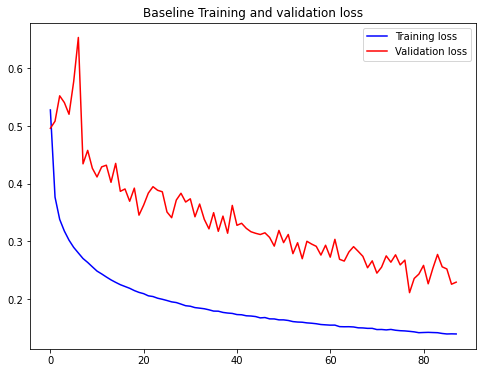

<Figure size 576x432 with 0 Axes>

MSE:  1.4073346071238673
MAE:  0.8712337104561786
R-Squared:  0.36843164089176894
Explained Variance Score:  0.4445144729506588


In [20]:
model_name = 'dense_model_posenet_ExreciseScore'

with mlflow.start_run(run_name=model_name) as run:

    run_id = run.info.run_id

    model = make_model(metrics=METRICS, 
                        loss='mean_squared_error', 
                        optimizer=optimizer, 
                        learning_rate=learning_rate, 
                        input_dim=input_dim)
    
    with tf.device('/CPU:0'):
        history = model.fit(
            x=X_train, 
            y=y_train, 
            shuffle=True, 
            epochs=EPOCHS, 
            verbose=1,
            batch_size=BATCH_SIZE,
            validation_split=0.2,
            callbacks=[early_stopping])

    # Plot training history
    plot_train_history(history, 'Baseline Training and validation loss')
    plt.savefig("training_history.jpg")
    mlflow.log_artifact("training_history.jpg")
    plt.show()
    
    # Log model, scaler, model parameters to MLflow
    #mlflow.log_param("activation", activation)
    #mlflow.log_param("kernel_initializer", kernel_initializer)
    #mlflow.log_param("output activation", output_activation)
    #mlflow.log_param("optimizer", optimizer)
    #mlflow.log_param("learning rate", learning_rate)
    #mlflow.log_param("batch size", BATCH_SIZE)
    #mlflow.log_param("epochs", early_stopping.stopped_epoch)
        
    #mlflow.log_param("input_mean_train", input_mean_train)
    #mlflow.log_param("input_std_train", input_std_train)
    #mlflow.log_param("input_mean_test", input_mean_test)
    #mlflow.log_param("input_std_test", input_std_test)
    #mlflow.log_param("output_mean", output_mean)
    #mlflow.log_param("output_std", output_std)

    # Log model performance
    process_time = [None] * 10
    
    for i in range(10):
        start_time = time.time()
        predictions = model.predict(X_test)
        end_time = time.time()
        process_time[i] = (end_time - start_time) * 1000
    
    predictions = (predictions * output_std_train.to_numpy()) + output_mean_train.to_numpy()
    
    output_mean_test = y_test.mean()
    output_std_test = y_test.std()
    y_test = (y_test - output_mean_test) / output_std_test
    y_test.to_numpy()
    
    (mse, mae, r2, variance) = eval_metrics(y_test, predictions)
    #mlflow.log_metric("mse", mse)
    #mlflow.log_metric("mae", mae)
    #mlflow.log_metric("R-squared", r2)
    #mlflow.log_metric("variance", variance)
    #mlflow.log_param("total params", model.count_params())
    #mlflow.log_metric("process time", np.mean(process_time)) 
    
    #mlflow.keras.log_model(model, model_name, signature=signature)

    # Print metrics
    print('MSE: ', mse)
    print('MAE: ', mae)
    print('R-Squared: ', r2)
    print('Explained Variance Score: ', variance)

In [21]:
## 5. Register Model

In [22]:
# model_uri = "runs:/{}/{}".format(run.info.run_id, model_name)
# mv = mlflow.register_model(model_uri, model_name)
# print("Name: {}".format(mv.name))
# print("Version: {}".format(mv.version))